In [ ]:
import numpy as np # linear algebra
import pandas as pd
import tensorflow as tf 
tf.__version__

'2.5.0-dev20210126'

In [6]:
!unzip /content/arabic-sentiment-twitter-corpus.zip

Streaming output truncated to the last 5000 lines.
  inflating: arabic_tweets/pos/5501.txt  
  inflating: arabic_tweets/pos/5502.txt  
  inflating: arabic_tweets/pos/5503.txt  
  inflating: arabic_tweets/pos/5504.txt  
  inflating: arabic_tweets/pos/5505.txt  
  inflating: arabic_tweets/pos/5506.txt  
  inflating: arabic_tweets/pos/5507.txt  
  inflating: arabic_tweets/pos/5508.txt  
  inflating: arabic_tweets/pos/5509.txt  
  inflating: arabic_tweets/pos/551.txt  
  inflating: arabic_tweets/pos/5510.txt  
  inflating: arabic_tweets/pos/5511.txt  
  inflating: arabic_tweets/pos/5512.txt  
  inflating: arabic_tweets/pos/5513.txt  
  inflating: arabic_tweets/pos/5514.txt  
  inflating: arabic_tweets/pos/5515.txt  
  inflating: arabic_tweets/pos/5516.txt  
  inflating: arabic_tweets/pos/5517.txt  
  inflating: arabic_tweets/pos/5518.txt  
  inflating: arabic_tweets/pos/5519.txt  
  inflating: arabic_tweets/pos/552.txt  
  inflating: arabic_tweets/pos/5520.txt  
  inflating: arabic_tweets/

In [7]:

!cd arabic_tweets/ && ls

neg  pos


In [8]:
data_dir ='/content/arabic_tweets' #

In [ ]:
! pip install tf-nightly 

     |████████████████████████████████| 400.8MB 42kB/s 
     |████████████████████████████████| 4.0MB 59.7MB/s 
     |████████████████████████████████| 4.0MB 39.8MB/s 
     |████████████████████████████████| 12.3MB 268kB/s 
     |████████████████████████████████| 471kB 60.9MB/s 
ERROR: tensorflow 2.4.0 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [9]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)

Found 58751 files belonging to 2 classes.
Using 47001 files for training.
Found 58751 files belonging to 2 classes.
Using 11750 files for validation.


In [10]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    data_dir, batch_size=batch_size
)

print(
    "Number of batches in raw_train_ds: %d"
    % tf.data.experimental.cardinality(raw_train_ds)
)
print(
    "Number of batches in raw_val_ds: %d" % tf.data.experimental.cardinality(raw_val_ds)
)
print(
    "Number of batches in raw_test_ds: %d"
    % tf.data.experimental.cardinality(raw_test_ds)
)

Found 58751 files belonging to 2 classes.
Number of batches in raw_train_ds: 1469
Number of batches in raw_val_ds: 368
Number of batches in raw_test_ds: 1836


In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i].decode('utf-8').strip())
        print(label_batch.numpy()[i])
        print('--------------------------------')

وشذا الحلم 😳
0
--------------------------------
أنا لما بحلم بكون مش عارف دا حلم ولا حقيقه وبعد لما بصحي بدور علي الحاجه اللي حلمت بيها 💥
0
--------------------------------
الحقد مزروع فيهم 🗡سبحان من علمهم بعلامات تعرف 😤 إلا من رحم ربي
0
--------------------------------
🕊🕊 💥 " لو كنت أضن إن كل الطيور تهاجر إليك💥 🕊🕊 لكنت كتبت على كل ريشة أشتقت إليك. 💥🕊💥 "
0
--------------------------------
- لما الاقي بنات الدفعه مقطعين في بعض علي ولد .. 🌚 = عاوزين رأيي ؟! .. حقيقي انتو نسوان معفنه 🤦‍♀️😂
1
--------------------------------


In [12]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )
max_features = 20000
embedding_dim = 128
sequence_length = 500
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [13]:
vectorize_layer

In [14]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [15]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_ds, epochs=10,
                    validation_data=val_ds,
                    validation_steps=30)

Epoch 1/10
1469/1469 [==============================] - 1132s 767ms/step - loss: 0.5140 - accuracy: 0.6623 - val_loss: 0.2081 - val_accuracy: 0.9198
Epoch 2/10
1469/1469 [==============================] - 1108s 754ms/step - loss: 0.1524 - accuracy: 0.9444 - val_loss: 0.1933 - val_accuracy: 0.9333
Epoch 3/10
1469/1469 [==============================] - 1093s 744ms/step - loss: 0.1077 - accuracy: 0.9622 - val_loss: 0.2137 - val_accuracy: 0.9375
Epoch 4/10
1469/1469 [==============================] - 1098s 748ms/step - loss: 0.1043 - accuracy: 0.9695 - val_loss: 0.2570 - val_accuracy: 0.9250
Epoch 5/10
1469/1469 [==============================] - 1098s 747ms/step - loss: 0.0682 - accuracy: 0.9787 - val_loss: 0.2784 - val_accuracy: 0.9260
Epoch 6/10
1469/1469 [==============================] - 1078s 734ms/step - loss: 0.0579 - accuracy: 0.9824 - val_loss: 0.2805 - val_accuracy: 0.9292
Epoch 7/10
1469/1469 [==============================] - 1078s 734ms/step - loss: 0.0522 - accuracy: 0.9843

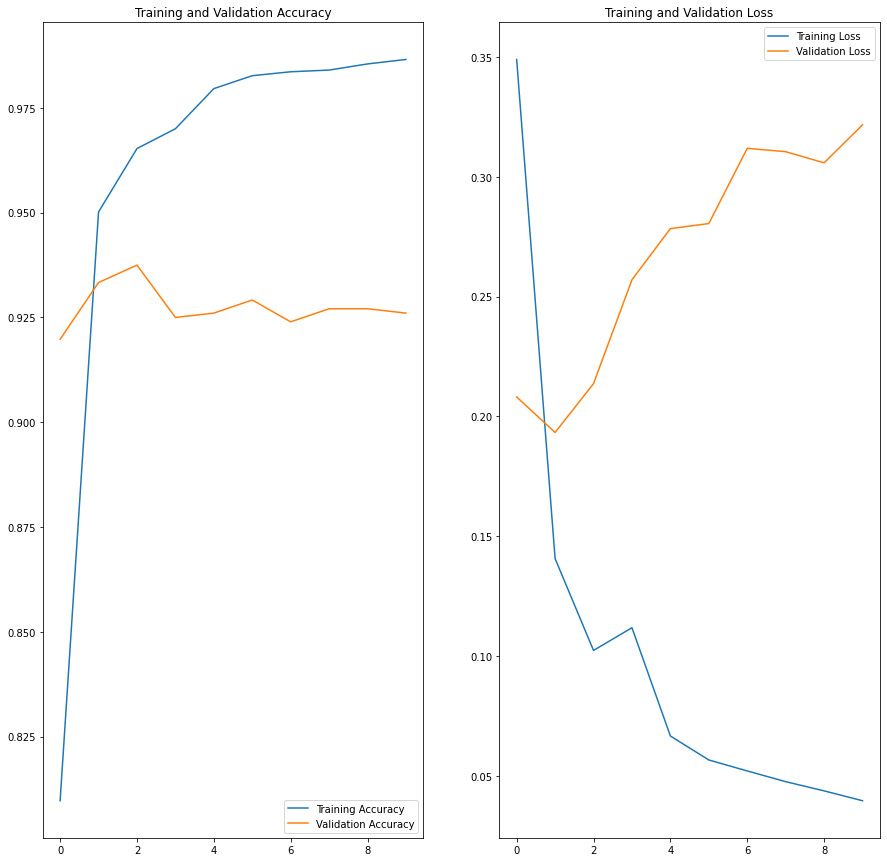

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

#epochs_range = range(22)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

1836/1836 [==============================] - 299s 163ms/step - loss: 0.0871 - accuracy: 0.9768
Test Loss: 0.08708123117685318
Test Accuracy: 0.9768174290657043
